GitHub link for the talk. You can clone the data and play with it yourself. Please submit any improvements as pull requests

[https://github.com/jseabold/538model](https://github.com/jseabold/538model)

In [1]:
import datetime

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas
from scipy import stats
np.set_printoptions(precision=4, suppress=True)
%matplotlib inline

#pandas.set_options(notebook_repr_html=False,
#                        precision=4,
#                        max_columns=12, column_space=10,
#                        max_colwidth=25)

In [2]:
today = datetime.datetime(2012, 10, 2)

## Outline

Methodology was obtained from the old [538 Blog](http://www.fivethirtyeight.com/2008/03/frequently-asked-questions-last-revised.html) with updates at the [new site hosted by the New York Times](http://fivethirtyeight.blogs.nytimes.com/methodology/)

1. Polling Average: Aggregate polling data, and weight it according to our reliability scores.

2. Trend Adjustment: Adjust the polling data for current trends.

3. Regression: Analyze demographic data in each state by means of regression analysis.

4. Snapshot: Combine the polling data with the regression analysis to produce an electoral snapshot. This is our estimate of what would happen if the election were held today.

5. Projection: Translate the snapshot into a projection of what will happen in November, by allocating out undecided voters and applying a discount to current polling leads based on historical trends.

6. Simulation: Simulate our results 10,000 times based on the results of the projection to account for the uncertainty in our estimates. The end result is a robust probabilistic assessment of what will happen in each state as well as in the nation as a whole. 

## Get the Data

### Consensus forecast of GDP growth over the next two economic quarters <br />(Median of WSJ's monthly forecasting panel)

The process for creating an economic index for the 538 model is described [here](http://fivethirtyeight.blogs.nytimes.com/2012/07/05/measuring-the-effect-of-the-economy-on-elections/#more-31732).

In [3]:
forecasts = pandas.read_csv("data_nuevo/wsj_forecast.csv")

In [4]:
forecasts

,Unnamed: 0,Unnamed: 0.1,Forecaster,Institution,gdp_q3_2012,gdp_q4_2012
0,0,0,Paul Ashworth,Capital Economics,2.0,1.5
1,1,1,Nariman Behravesh,IHS Global Insight,1.5,1.6
2,2,2,Richard Berner/ David Greenlaw *,Morgan Stanley,NaN,NaN
3,3,3,Ram Bhagavatula,Combinatorics Capital,2.0,4.0
4,4,4,Beth Ann Bovino *,Standard and Poor's,NaN,NaN
5,5,5,Jay Brinkmann,Mortgage Bankers Association,1.8,1.9
6,6,6,Michael Carey,Credit Agricole CIB,1.7,1.6
7,7,7,Joseph Carson,AllianceBernstein,2.5,3.5
8,8,8,Julia Coronado,BNP Paribas,1.4,1.6
9,9,9,Mike Cosgrove,Econoclast,1.6,1.6


In [5]:
median_forecast = forecasts[['gdp_q3_2012', 'gdp_q4_2012']].median()

In [6]:
median_forecast

gdp_q3_2012    1.8
gdp_q4_2012    1.8
dtype: float64

### Polling Data

I used Python to scrape the [Real Clear Politics](realclearpolitics.com) website and download data for the 2004 and 2008 elections. The scraping scripts are available in the github repository for this talk. State by state historical data for the 2004 and 2008 Presidential elections was obtained from [electoral-vote.com](www.electorical-vote.com).

## Polling Average

Details can be found at the 538 blog [here](http://www.fivethirtyeight.com/2008/03/pollster-ratings-updated.html).

In [7]:
tossup = ["Colorado", "Florida", "Iowa", "New Hampshire", "Nevada", 
          "Ohio", "Virginia", "Wisconsin"]

In [8]:
national_data2012 = pandas.read_pickle("data_nuevo/2012_poll_data_national.pkl")

In [9]:
national_data2012.head(5)

,Pollster,Sample,MoE,Obama (D),Romney (R),Spread,obama_spread,State,poll_date
0,RCP Average,NaN,--,49.1,45.1,Obama +4.0,4,USA,2012-09-28
1,Rasmussen Tracking,1500,3.0,48.0,47.0,Obama +1,1,USA,2012-09-30
2,CNN/Opinion Research,783,3.5,50.0,47.0,Obama +3,3,USA,2012-09-29
3,Gallup Tracking,3050,2.0,50.0,44.0,Obama +6,6,USA,2012-09-28
4,Quinnipiac,1912,2.2,49.0,45.0,Obama +4,4,USA,2012-09-28


In [10]:
state_data2012 = pandas.read_pickle("data_nuevo/2012_poll_data_states.pkl")

In [11]:
state_data2012.head(5)

,Pollster,State,MoE,Obama (D),Romney (R),Sample,Spread,obama_spread,poll_date
0,Rasmussen Reports,WA,4.5,52,41,500,Obama +11,11,2012-09-26
1,Gravis Marketing,WA,4.6,56,39,625,Obama +17,17,2012-09-22
2,Elway Poll,WA,5.0,53,36,405,Obama +17,17,2012-09-11
3,SurveyUSA,WA,4.4,54,38,524,Obama +16,16,2012-09-08
4,SurveyUSA,WA,4.4,54,37,524,Obama +17,17,2012-08-02


In [12]:
pollsters = state_data2012.Pollster.unique()
pollsters.sort()

In [13]:
len(pollsters)

120

In [14]:
print pandas.Series(pollsters)

0                AFP/Magellan (R)
1              AIF/McLaughlin (R)
2                             ARG
3            Albuquerque Journal*
4                   Arizona State
5                   Baltimore Sun
6              Baydoun/Foster (D)
7        Behavior Research Center
8                  Bloomberg News
9                    Boston Globe
10             CBS/NYT/Quinnipiac
11           CNN/Opinion Research
                  ...            
108           Virginian-Pilot/ODU
109    Voter/Consumer Res/TIR (R)
110                  WBUR/MassINC
111                      WMUR/UNH
112                           WPA
113               WPR/St. Norbert
114                          WPRI
115                  WPRI/Fleming
116               Washington Post
117                  WeAskAmerica
118                 WeAskAmerica*
119         Western NE University
dtype: object


### 538 Pollster Ratings

In [15]:
weights = pandas.read_table("./data/pollster_weights.csv")

In [16]:
weights

,Pollster,Weight,PIE
0,ABC / Washington Post,0.95,1.41
1,American Research Group,0.65,1.76
2,CBS / New York Times,0.66,1.84
3,Chicago Trib. / MarketShares,1.16,1.13
4,CNN / Opinion Research,0.77,1.59
5,Columbus Dispatch (OH),0.50,6.76
6,EPIC-MRA,0.75,1.65
7,Fairleigh-Dickinson (NJ),0.71,1.72
8,Field Poll (CA),1.33,0.88
9,Fox / Opinion Dynamics,0.79,1.60


In [17]:
weights.mean()

Weight    0.907813
PIE       1.706563
dtype: float64

Clean up the pollster names a bit so we can merge with the weights.

In [18]:
import pickle
pollster_map = pickle.load(open("./data/pollster_map.pkl", "rb"))

In [19]:
state_data2012.Pollster.replace(pollster_map, inplace=True);

In [20]:
national_data2012.Pollster.replace(pollster_map, inplace=True);

Inner merge the data with the weights

In [21]:
state_data2012 = state_data2012.merge(weights, how="inner", on="Pollster")

In [22]:
state_data2012.head(5)

,Pollster,State,MoE,Obama (D),Romney (R),Sample,Spread,obama_spread,poll_date,Weight,PIE
0,Rasmussen,WA,4.5,52,41,500,Obama +11,11,2012-09-26,1.3,0.88
1,Rasmussen,WI,4.5,49,46,500,Obama +3,3,2012-09-17,1.3,0.88
2,Rasmussen,WI,4.5,47,48,500,Romney +1,-1,2012-08-15,1.3,0.88
3,Rasmussen,WI,4.5,49,46,500,Obama +3,3,2012-07-25,1.3,0.88
4,Rasmussen,WI,4.5,44,47,500,Romney +3,-3,2012-06-12,1.3,0.88


In [23]:
state_data2012.dtypes

Pollster                object
State                   object
MoE                    float64
Obama (D)              float64
Romney (R)             float64
Sample                 float64
Spread                  object
obama_spread           float64
poll_date       datetime64[ns]
Weight                 float64
PIE                    float64
dtype: object

#### First, we average each pollster for each state.

The first adjustment is an exponential decay for recency of the poll. Based on research in prior elections, a weight with a half-life of 30 days since the median date the poll has been in the field is assigned to each poll.

In [24]:
def exp_decay(x):
    # defensive coding, accepts timedeltas
    #days = getattr(days, "days", days)
    days = x.astype('timedelta64[D]')/ np.timedelta64(1, 'D')
    # print("days is", type(days))
    return .5 ** (days/30.)

(0, 45)

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


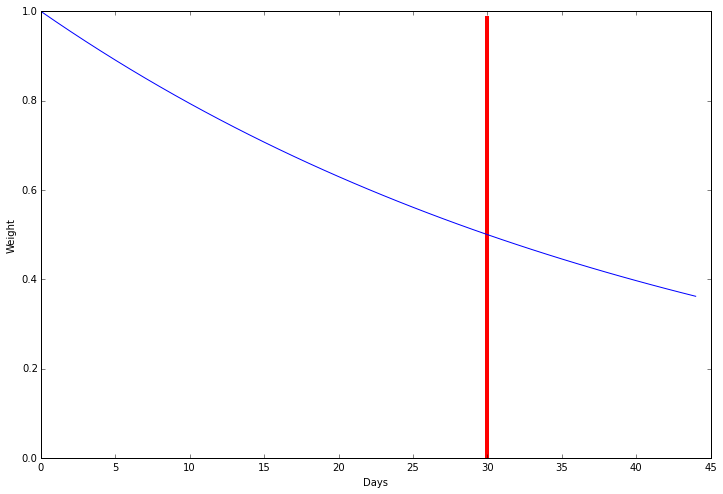

In [25]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={"xlabel" : "Days",
                                                   "ylabel" : "Weight"})
days = np.arange(0, 45)
ax.plot(days, exp_decay(days));
ax.vlines(30, 0, .99, color='r', linewidth=4)
ax.set_ylim(0,1)
ax.set_xlim(0, 45)


The second adjustment is for the sample size of the poll. Polls with a higher sample size receive a higher weight.

Binomial sampling error = +/- $50 * \frac{1}{\sqrt{nobs}}$ where the 50 depends on the underlying probability or population preferences, in this case assumed to be 50:50 (another way of calculating Margin of Error)

In [26]:
def average_error(nobs, p=50.):
    return p*nobs**-.5

The thinking here is that having 5 polls of 1200 is a lot like having one poll of 6000. However, we downweight older polls by only including the marginal effective sample size. Where the effective sample size is the size of the methodologically perfect poll for which we would be indifferent between it and the one we have with our current total error. Total error is determined as $TE = \text{Average Error} + \text{Long Run Pollster Induced Error}$. See [here](http://www.fivethirtyeight.com/2008/04/pollster-ratings-v30.html) for the detailed calculations of Pollster Induced Error.

In [27]:
def effective_sample(total_error, p=50.):
    return p**2 * (total_error**-2.)

In [28]:
state_pollsters = state_data2012.groupby(["State", "Pollster"])

In [29]:
ppp_az = state_pollsters.get_group(("AZ", "Public Policy Polling (PPP)"))

In [30]:
var_idx = ["Pollster", "State", "Obama (D)", "Romney (R)", "Sample", "poll_date"]
ppp_az[var_idx]

,Pollster,State,Obama (D),Romney (R),Sample,poll_date
258,Public Policy Polling (PPP),AZ,44,53,993,2012-09-08
259,Public Policy Polling (PPP),AZ,41,52,833,2012-07-24
260,Public Policy Polling (PPP),AZ,43,50,500,2012-05-19
261,Public Policy Polling (PPP),AZ,47,47,743,2012-02-18
262,Public Policy Polling (PPP),AZ,42,49,500,2011-11-19
263,Public Policy Polling (PPP),AZ,44,48,623,2011-04-30
264,Public Policy Polling (PPP),AZ,43,49,599,2011-01-29
265,Public Policy Polling (PPP),AZ,43,50,617,2010-09-20


In [31]:
ppp_az.sort("poll_date", ascending=False, inplace=True);

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/pandas/core/frame.py:3167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace, kind=kind, na_position=na_position)


In [32]:
ppp_az["cumulative"] = ppp_az["Sample"].cumsum()
ppp_az["average_error"] = average_error(ppp_az["cumulative"])
ppp_az["total_error"] = ppp_az["PIE"] + ppp_az["average_error"]
ppp_az[var_idx + ["cumulative"]]

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

,Pollster,State,Obama (D),Romney (R),Sample,poll_date,cumulative
258,Public Policy Polling (PPP),AZ,44,53,993,2012-09-08,993
259,Public Policy Polling (PPP),AZ,41,52,833,2012-07-24,1826
260,Public Policy Polling (PPP),AZ,43,50,500,2012-05-19,2326
261,Public Policy Polling (PPP),AZ,47,47,743,2012-02-18,3069
262,Public Policy Polling (PPP),AZ,42,49,500,2011-11-19,3569
263,Public Policy Polling (PPP),AZ,44,48,623,2011-04-30,4192
264,Public Policy Polling (PPP),AZ,43,49,599,2011-01-29,4791
265,Public Policy Polling (PPP),AZ,43,50,617,2010-09-20,5408


In [33]:
ppp_az["ESS"] = effective_sample(ppp_az["total_error"])
ppp_az["MESS"] = ppp_az["ESS"].diff()
# fill in first one
ppp_az["MESS"].fillna(ppp_az["ESS"].head(1).item(), inplace=True);

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/pandas/core/generic.py:2862: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

In [34]:
ppp_az[["poll_date", "Sample", "cumulative", "ESS", "MESS"]]

,poll_date,Sample,cumulative,ESS,MESS
258,2012-09-08,993,993,246.182451,246.182451
259,2012-07-24,833,1826,325.800656,79.618204
260,2012-05-19,500,2326,359.591232,33.790577
261,2012-02-18,743,3069,399.185055,39.593822
262,2011-11-19,500,3569,420.967611,21.782557
263,2011-04-30,623,4192,444.240505,23.272893
264,2011-01-29,599,4791,463.531139,19.290634
265,2010-09-20,617,5408,480.955020,17.423881


Now let's do it for every polling firm in every state.

In [35]:
def calculate_mess(group):
    cumulative = group["Sample"].cumsum()
    ae = average_error(cumulative)
    total_error = ae + group["PIE"]
    ess = effective_sample(total_error)
    mess = ess.diff()
    mess.fillna(ess.head(1).item(), inplace=True)
    #from IPython.core.debugger import Pdb; Pdb().set_trace()
    return pandas.concat((ess, mess), axis=1)

#state_data2012["ESS", "MESS"] 
df = state_pollsters.apply(calculate_mess)
df.rename(columns={0 : "ESS", 1 : "MESS"}, inplace=True);

In [36]:
state_data2012 = state_data2012.join(df)

Give them the time weight

In [37]:
state_data2012["poll_date"].head(1)

0   2012-09-26
Name: poll_date, dtype: datetime64[ns]

In [38]:
state_data2012["time_weight"] = (today - state_data2012["poll_date"]).apply(exp_decay)

In [39]:
state_data2012["time_weight"]

0      0.870551
1      0.707107
2      0.329877
3      0.203063
4      0.075189
5      0.034276
6      0.012691
7      0.006494
8      0.000370
9      0.629961
10     0.329877
11     0.140308
         ...   
411    0.445449
412    0.217638
413    0.062500
414    0.014579
415    0.002893
416    0.000587
417    0.000031
418    0.000001
419    0.396850
420    0.314980
421    0.193893
422    0.086370
Name: time_weight, dtype: float64

Now aggregate all of these. Weight them based on the sample size but also based on the time_weight.

In [40]:
def weighted_mean(group):
    weights1 = group["time_weight"]
    weights2 = group["MESS"]
    return np.sum(weights1*weights2*group["obama_spread"]/(weights1*weights2).sum())

In [41]:
state_pollsters = state_data2012.groupby(["State", "Pollster"])
state_polls = state_pollsters.apply(weighted_mean)

In [42]:
state_polls

State  Pollster                   
AZ     Public Policy Polling (PPP)    -9.168494
       Rasmussen                     -10.209446
CA     Field Poll (CA)                23.343924
       Public Policy Polling (PPP)    20.999075
       Rasmussen                      22.000000
       SurveyUSA                      22.123414
CO     American Research Group         2.000000
       Public Policy Polling (PPP)     5.469907
       Rasmussen                      -1.573788
CT     Public Policy Polling (PPP)    12.757757
       Quinnipiac                      7.293983
       Rasmussen                       8.000000
                                        ...    
VA     Mason-Dixon                     1.000000
       Public Policy Polling (PPP)     5.095802
       Quinnipiac                      0.578138
       Rasmussen                       0.891780
VT     Public Policy Polling (PPP)    20.000000
WA     Public Policy Polling (PPP)    13.050886
       Rasmussen                      11.000000
     

### 2004 and 2008 Polls

In [43]:
state_data2008= pandas.read_pickle("data_nuevo/state_data_2008.pkl"); state_data2004 = pandas.read_pickle("data_nuevo/state_data_2004.pkl")

In [44]:
state_data2008.dtypes

State                object
Obama                 int64
McCain                int64
Pollster             object
poll_date    datetime64[ns]
dtype: object

In [45]:
state_data2004.dtypes

State                object
Kerry                 int64
Bush                  int64
Pollster             object
poll_date    datetime64[ns]
dtype: object

In [46]:
state_data2004.head(5)

,State,Kerry,Bush,Pollster,poll_date
0,AL,39,57,SurveyUSA,2004-10-25
1,AL,32,56,Capital Survey,2004-10-12
2,AL,34,62,SurveyUSA,2004-10-01
3,AL,40,54,ARG,2004-09-14
4,AL,42,53,Rasmussen,2004-09-06


In [47]:
state_data2008.head(5)

,State,Obama,McCain,Pollster,poll_date
0,AL,36,61,SurveyUSA,2008-10-28
1,AL,34,54,Capital Survey,2008-10-16
2,AL,35,62,SurveyUSA,2008-10-09
3,AL,35,55,Capital Survey,2008-10-07
4,AL,39,60,Rasmussen,2008-09-22


In [48]:
state_groups = state_data2008.groupby("State")

In [49]:
state_groups.aggregate(dict(Obama=np.mean, McCain=np.mean))

,McCain,Obama
State,,
AK,52.000000,39.428571
AL,56.826087,34.347826
AR,51.000000,37.250000
AZ,49.333333,39.190476
CA,37.633333,53.266667
CO,44.466667,48.288889
CT,36.923077,52.692308
DC,13.000000,82.000000
DE,38.625000,55.500000


Means for the entire country (without weighting by population)

In [50]:
state_groups.aggregate(dict(Obama=np.mean, McCain=np.mean)).mean()

McCain    45.337861
Obama     46.082498
dtype: float64

In [51]:
state_data2004.Pollster.replace(pollster_map, inplace=True)
state_data2008.Pollster.replace(pollster_map, inplace=True);

In [52]:
state_data2004 = state_data2004.merge(weights, how="inner", on="Pollster")
state_data2008 = state_data2008.merge(weights, how="inner", on="Pollster")

In [53]:
len(state_data2004.Pollster.unique())

26

In [54]:
len(state_data2008.Pollster.unique())

21

In [55]:
date2004 = datetime.datetime(2004, 11, 2)
date2004

datetime.datetime(2004, 11, 2, 0, 0)

In [56]:
(date2004 - state_data2004.poll_date) < datetime.timedelta(21)

0       True
1      False
2      False
3       True
4       True
5      False
6      False
7      False
8       True
9       True
10      True
11     False
       ...  
722     True
723    False
724    False
725    False
726    False
727    False
728     True
729    False
730     True
731    False
732     True
733     True
Name: poll_date, dtype: bool

Restrict the samples to the 3 weeks leading up to the election

In [57]:
state_data2004 = state_data2004.ix[(date2004 - state_data2004.poll_date) <= datetime.timedelta(21)]
state_data2004.reset_index(drop=True, inplace=True)

In [58]:
date2008 = datetime.datetime(2008, 11, 4)

In [59]:
state_data2008 = state_data2008.ix[(date2008 - state_data2008.poll_date) <= datetime.timedelta(21)]
state_data2008.reset_index(drop=True, inplace=True)

In [60]:
state_data2008.dtypes

State                object
Obama                 int64
McCain                int64
Pollster             object
poll_date    datetime64[ns]
Weight              float64
PIE                 float64
dtype: object

In [61]:
state_data2004["time_weight"] =(date2004 - state_data2004.poll_date).apply(exp_decay)
state_data2008["time_weight"] =(date2008 - state_data2008.poll_date).apply(exp_decay)

In [62]:
state_data2004[["time_weight", "poll_date"]].head(5)

,time_weight,poll_date
0,0.831238,2004-10-25
1,0.890899,2004-10-28
2,0.690956,2004-10-17
3,0.977160,2004-11-01
4,0.793701,2004-10-23


In [63]:
def max_date(x):
    return x == x.max()

In [64]:
state_data2004["newest_poll"] = state_data2004.groupby(("State", "Pollster")).poll_date.transform(max_date)
state_data2008["newest_poll"] = state_data2008.groupby(("State", "Pollster")).poll_date.transform(max_date)

### Clustering States by Demographics

There are notes on trend line adjustment, [here](http://www.fivethirtyeight.com/2008/06/we-know-more-than-we-think-big-change-2.html), [here](http://www.fivethirtyeight.com/2008/06/refinement-to-adjustment-part-i.html), [here](http://www.fivethirtyeight.com/2008/06/refinement-to-adjustment-part-ii.html), [here](http://www.fivethirtyeight.com/2008/06/trendline-now-calculated-from-daily.html), and [here](http://www.fivethirtyeight.com/2008/06/construction-season-over-technical.html). However, to the best of my knowledge, the similar state "nearest neighbor" clustering remains a black box.

Partican Voting Index data obtained from [Wikipedia](http://en.wikipedia.org/wiki/Cook_Partisan_Voting_Index)

In [65]:
pvi = pandas.read_csv("./data/partisan_voting.csv") 


In [66]:
pvi.set_index("State", inplace=True);
pvi

,PVI
State,
Alabama,R+13
Alaska,R+13
Arizona,R+6
Arkansas,R+9
California,D+7
Colorado,EVEN
Connecticut,D+7
Delaware,D+7
District of Columbia,D+39


In [67]:
pvi.PVI = pvi.PVI.replace({"EVEN" : "0"})
pvi.PVI = pvi.PVI.str.replace("R\+", "-")
pvi.PVI = pvi.PVI.str.replace("D\+", "")
pvi.PVI = pvi.PVI.astype(float)
pvi.PVI

State
Alabama                -13
Alaska                 -13
Arizona                 -6
Arkansas                -9
California               7
Colorado                 0
Connecticut              7
Delaware                 7
District of Columbia    39
Florida                 -2
Georgia                 -7
Hawaii                  12
                        ..
Rhode Island            11
South Carolina          -8
South Dakota            -9
Tennessee               -9
Texas                  -10
Utah                   -20
Vermont                 13
Virginia                -2
Washington               5
West Virginia           -8
Wisconsin                2
Wyoming                -20
Name: PVI, dtype: float64

Party affliation of electorate obtained from [Gallup](http://www.gallup.com/poll/156437/Heavily-Democratic-States-Concentrated-East.aspx#2).

In [68]:
party_affil = pandas.read_csv("./data/gallup_electorate.csv")

In [69]:
party_affil.Democrat = party_affil.Democrat.str.replace("%", "").astype(float)
party_affil.Republican = party_affil.Republican.str.replace("%", "").astype(float)
party_affil.set_index("State", inplace=True);
party_affil.rename(columns={"Democrat Advantage" : "dem_adv"}, inplace=True);
party_affil["no_party"] = 100 - party_affil.Democrat - party_affil.Republican

In [70]:
party_affil

,Democrat,Republican,dem_adv,N,no_party
State,,,,,
District of Columbia,79.0,12.7,66.3000,416,8.3
Rhode Island,52.5,26.5,26.0000,623,21.0
Hawaii,54.3,28.7,25.6000,466,17.0
New York,52.0,30.8,21.2000,8674,17.2
Maryland,54.0,33.8,20.2000,3571,12.2
Massachusetts,52.5,33.4,19.1000,3583,14.1
Delaware,50.5,33.1,17.4000,540,16.4
Connecticut,49.8,34.4,15.4000,2020,15.8
Vermont,48.8,34.9,13.9000,550,16.3


In [71]:
census_data = pandas.read_csv("./data/census_demographics.csv")

In [72]:
def capitalize(s):
    s = s.title()
    s = s.replace("Of", "of")
    return s

In [73]:
census_data["State"] = census_data.state.map(capitalize)
del census_data["state"]

In [74]:
census_data.set_index("State", inplace=True)

In [75]:
states_abbrev_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

Campaign Contributions from FEC.

In [76]:
obama_give = pandas.read_csv("./data/obama_indiv_state.csv", 
                             header=None, names=["State", "obama_give"])
romney_give = pandas.read_csv("./data/romney_indiv_state.csv",
                             header=None, names=["State", "romney_give"])

In [77]:
obama_give.State.replace(states_abbrev_dict, inplace=True);
romney_give.State.replace(states_abbrev_dict, inplace=True);

In [78]:
obama_give.set_index("State", inplace=True)
romney_give.set_index("State", inplace=True);

In [79]:
demo_data = census_data.join(party_affil[["dem_adv", "no_party"]]).join(pvi)

In [80]:
demo_data = demo_data.join(obama_give).join(romney_give)

In [81]:
giving = demo_data[["obama_give", "romney_give"]].div(demo_data[["vote_pop", "older_pop"]].sum(1), axis=0)
giving

,obama_give,romney_give
State,,
Alabama,0.244651,0.365672
Alaska,1.111870,0.498678
Arizona,0.568634,0.672651
Arkansas,0.246781,0.216652
California,1.128145,0.617581
Colorado,1.056366,0.796661
Connecticut,1.206698,1.544816
Delaware,0.766860,0.358712
District of Columbia,326.863621,2.535392


In [82]:
demo_data[["obama_give", "romney_give"]] = giving

In [83]:
from scipy import cluster as sp_cluster
from sklearn import cluster, neighbors

In [84]:
clean_data = sp_cluster.vq.whiten(demo_data.values)

In [85]:
clean_data.var(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [86]:
KNN = neighbors.NearestNeighbors(n_neighbors=7)
KNN.fit(clean_data)
KNN.kneighbors(clean_data[0], return_distance=True)

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(array([[ 0.    ,  0.895 ,  1.4131,  1.4377,  2.0061,  2.1917,  2.3806]]),
 array([[ 0, 40, 18, 42, 24, 33, 17]]))

In [87]:
idx = _[1]
demo_data.index[0], demo_data.index[idx]

('Alabama',
 Index([[u'Alabama', u'South Carolina', u'Louisiana', u'Tennessee', u'Mississippi', u'North Carolina', u'Kentucky']], dtype='object', name=u'State'))

In [88]:
nearest_neighbor = {}
for i, state in enumerate(demo_data.index):
    neighborhood = KNN.kneighbors(clean_data[i], return_distance=True)
    nearest_neighbor.update({state : (demo_data.index[neighborhood[1]],
                                     neighborhood[0])})

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a sin

In [89]:
nearest_neighbor

{'Alabama': (Index([[u'Alabama', u'South Carolina', u'Louisiana', u'Tennessee', u'Mississippi', u'North Carolina', u'Kentucky']], dtype='object', name=u'State'),
  array([[ 0.    ,  0.895 ,  1.4131,  1.4377,  2.0061,  2.1917,  2.3806]])),
 'Alaska': (Index([[u'Alaska', u'Colorado', u'Wyoming', u'Washington', u'Virginia', u'Nevada', u'New Hampshire']], dtype='object', name=u'State'),
  array([[ 0.    ,  4.3342,  4.5308,  4.7701,  4.9261,  4.9871,  5.2991]])),
 'Arizona': (Index([[u'Arizona', u'Oklahoma', u'New Mexico', u'Kansas', u'Nevada', u'North Carolina', u'Oregon']], dtype='object', name=u'State'),
  array([[ 0.    ,  2.9343,  2.9355,  3.1193,  3.1995,  3.3985,  3.4008]])),
 'Arkansas': (Index([[u'Arkansas', u'Tennessee', u'Alabama', u'Missouri', u'Indiana', u'Kentucky', u'South Carolina']], dtype='object', name=u'State'),
  array([[ 0.    ,  2.2112,  2.4606,  2.612 ,  2.6739,  2.7217,  2.7387]])),
 'California': (Index([[u'California', u'Texas', u'New York', u'Illinois', u'Florida

In [90]:
k_means = cluster.KMeans(n_clusters=5, n_init=50)
k_means.fit(clean_data)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_

In [91]:
clusters = sp_cluster.vq.kmeans(clean_data, 5)[0]

In [92]:
def choose_group(data, clusters):
    """
    Return the index of the cluster to which the rows in data
    are "closest" (in the sense of the L2-norm)
    """
    data = data[:,None] # add an axis for broadcasting
    distances = data - clusters
    groups = []
    for row in distances:
        dists = map(np.linalg.norm, row)
        groups.append(np.argmin(dists))
    return groups

In [93]:
groups = choose_group(clean_data, clusters)

In [94]:
np.array(groups)

array([2, 4, 1, 2, 3, 4, 4, 4, 0, 3, 2, 4, 1, 4, 1, 1, 1, 2, 2, 1, 4, 4, 1, 4, 2, 1, 1, 1, 1, 4, 4, 1, 3, 2, 1, 1, 1, 1, 1, 4, 2, 1, 2, 3, 1, 4, 4, 4, 2, 1, 1])

Or use a one-liner

In [95]:
groups = [np.argmin(map(np.linalg.norm, (clean_data[:,None] - clusters)[i])) for i in range(51)]

In [96]:
demo_data["kmeans_group"] = groups
demo_data["kmeans_labels"] = labels

In [97]:
for _, group in demo_data.groupby("kmeans_group"):
    group = group.index
    group.values.sort()
    print group.values

['District of Columbia']
['Arizona' 'Idaho' 'Indiana' 'Iowa' 'Kansas' 'Maine' 'Michigan' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Mexico' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon'
 'Pennsylvania' 'South Dakota' 'Utah' 'Wisconsin' 'Wyoming']
['Alabama' 'Arkansas' 'Georgia' 'Kentucky' 'Louisiana' 'Mississippi' 'North Carolina' 'South Carolina' 'Tennessee' 'West Virginia']
['California' 'Florida' 'New York' 'Texas']
['Alaska' 'Colorado' 'Connecticut' 'Delaware' 'Hawaii' 'Illinois' 'Maryland' 'Massachusetts' 'Minnesota' 'New Hampshire' 'New Jersey' 'Rhode Island' 'Vermont'
 'Virginia' 'Washington']


In [98]:
labels

array([4, 3, 0, 4, 2, 3, 3, 3, 1, 2, 4, 3, 0, 3, 0, 0, 0, 4, 4, 0, 3, 3, 0, 3, 4, 0, 0, 0, 3, 3, 3, 4, 2, 4, 0, 0, 4, 0, 0, 3, 4, 0, 4, 2, 0, 3, 3, 3, 4, 0, 0], dtype=int32)

In [99]:
demo_data["kmeans_labels"] = labels
for _, group in demo_data.groupby("kmeans_labels"):
    group = group.index.copy()
    group.values.sort()
    print group.values

['Arizona' 'Idaho' 'Indiana' 'Iowa' 'Kansas' 'Maine' 'Michigan' 'Missouri' 'Montana' 'Nebraska' 'North Dakota' 'Ohio' 'Oregon' 'Pennsylvania' 'South Dakota'
 'Utah' 'Wisconsin' 'Wyoming']
['District of Columbia']
['California' 'Florida' 'New York' 'Texas']
['Alaska' 'Colorado' 'Connecticut' 'Delaware' 'Hawaii' 'Illinois' 'Maryland' 'Massachusetts' 'Minnesota' 'Nevada' 'New Hampshire' 'New Jersey' 'Rhode Island'
 'Vermont' 'Virginia' 'Washington']
['Alabama' 'Arkansas' 'Georgia' 'Kentucky' 'Louisiana' 'Mississippi' 'New Mexico' 'North Carolina' 'Oklahoma' 'South Carolina' 'Tennessee' 'West Virginia']


In [100]:
demo_data = demo_data.reset_index()

In [101]:
state_data2012.State.replace(states_abbrev_dict, inplace=True);

In [102]:
state_data2012 = state_data2012.merge(demo_data[["State", "kmeans_labels"]], on="State")

In [103]:
kmeans_groups = state_data2012.groupby("kmeans_labels")

In [104]:
group = kmeans_groups.get_group(kmeans_groups.groups.keys()[2])

In [105]:
group.State.unique()

array(['Washington', 'New Hampshire', 'New Jersey', 'Nevada', 'Colorado', 'Connecticut', 'Virginia', 'Massachusetts', 'Rhode Island', 'Hawaii', 'Vermont',
       'Maryland', 'Minnesota', 'Illinois'], dtype=object)

In [106]:
def edit_tick_label(tick_val, tick_pos):
    if tick_val  < 0:
        text = str(int(tick_val)).replace("-", "Romney+")
    else:
        text = "Obama+"+str(int(tick_val))
    return text

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


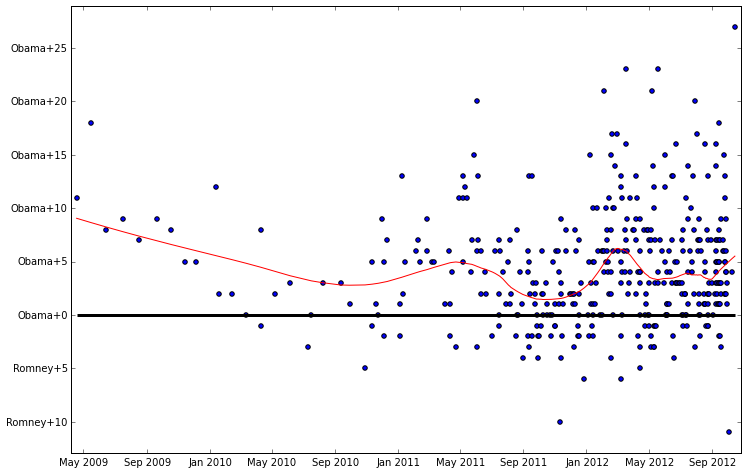

In [107]:
from pandas import lib
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(figsize=(12,8))

data = group[["poll_date", "obama_spread"]]
data = pandas.concat((data, national_data2012[["poll_date", "obama_spread"]]))
    
data.sort("poll_date", inplace=True)
dates = pandas.DatetimeIndex(data.poll_date).asi8

loess_res = sm.nonparametric.lowess(data.obama_spread.values, dates, 
                                    frac=.2, it=3)

dates_x = pandas.to_datetime(dates)
axes.scatter(dates_x, data["obama_spread"])
axes.plot(dates_x, loess_res[:,1], color='r')
axes.yaxis.get_major_locator().set_params(nbins=12)
axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='x')
axes.hlines(0, dates_x[0], dates_x[-1], color='black', lw=3)
axes.margins(0, .05)

In [108]:
loess_res[-7:,1].mean()

5.0108108613106328

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


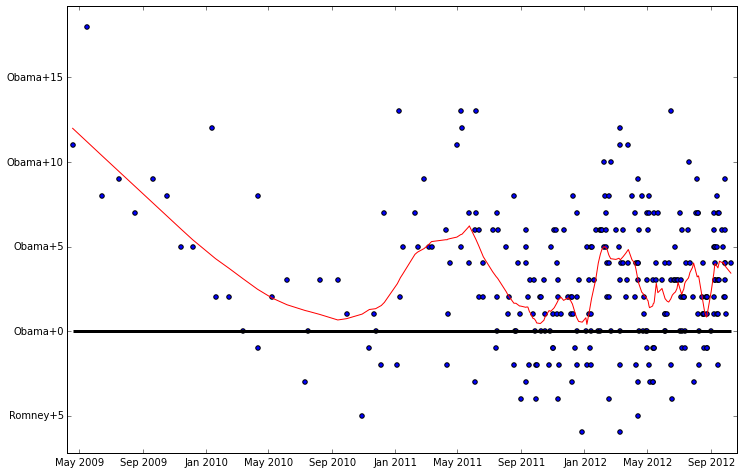

In [109]:
from pandas import lib
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(figsize=(12,8))

national_data2012.sort("poll_date", inplace=True)
dates = pandas.DatetimeIndex(national_data2012.poll_date).asi8

loess_res = sm.nonparametric.lowess(national_data2012.obama_spread.values, dates, 
                                    frac=.075, it=3)

dates_x = pandas.to_datetime(dates)
axes.scatter(dates_x, national_data2012["obama_spread"])
axes.plot(dates_x, loess_res[:,1], color='r')
axes.yaxis.get_major_locator().set_params(nbins=12)
axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='x')
axes.hlines(0, dates_x[0], dates_x[-1], color='black', lw=3)
axes.margins(0, .05)

In [110]:
trends = []
for i, group in kmeans_groups:
    data = group[["poll_date", "obama_spread"]]
    data = pandas.concat((data, national_data2012[["poll_date", "obama_spread"]]))
    
    data.sort("poll_date", inplace=True)
    dates = pandas.DatetimeIndex(data.poll_date).asi8

    loess_res = sm.nonparametric.lowess(data.obama_spread.values, dates, 
                                    frac=.1, it=3)
    states = group.State.unique()
    for state in states:
        trends.append([state, loess_res[-7:,1].mean()])

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [111]:
trends

[['Wisconsin', 5.3767534315390426],
 ['North Dakota', 5.3767534315390426],
 ['Nebraska', 5.3767534315390426],
 ['Ohio', 5.3767534315390426],
 ['Pennsylvania', 5.3767534315390426],
 ['Indiana', 5.3767534315390426],
 ['Iowa', 5.3767534315390426],
 ['Arizona', 5.3767534315390426],
 ['Maine', 5.3767534315390426],
 ['Missouri', 5.3767534315390426],
 ['Michigan', 5.3767534315390426],
 ['Montana', 5.3767534315390426],
 ['Kansas', 5.3767534315390426],
 ['Oregon', 5.3767534315390426],
 ['South Dakota', 5.3767534315390426],
 ['Utah', 5.3767534315390426],
 ['Florida', 3.3877002862540975],
 ['California', 3.3877002862540975],
 ['New York', 3.3877002862540975],
 ['Texas', 3.3877002862540975],
 ['Washington', 4.5126101123209397],
 ['New Hampshire', 4.5126101123209397],
 ['New Jersey', 4.5126101123209397],
 ['Nevada', 4.5126101123209397],
 ['Colorado', 4.5126101123209397],
 ['Connecticut', 4.5126101123209397],
 ['Virginia', 4.5126101123209397],
 ['Massachusetts', 4.5126101123209397],
 ['Rhode Island'

#### Adjust for sensitivity to time-trends

$$\text{Margin}=X_i+Z_t+\epsilon$$

where $S_i$ are Pollster:State dummies. In a state with a time-dependent trend, you might write

$$\text{Margin}=X_i+m*Z_t$$

where $m$ is a multiplier representing uncertainty in the time-trend parameter. Solving for $m$ gives

$$m=\text{Margin}-\frac{X_i}{Z_t}$$

In [112]:
from statsmodels.formula.api import ols, wls

In [113]:
#pollster_state_dummy = state_data2012.groupby(["Pollster", "State"])["obama_spread"].mean()
#daily_dummy = state_data2012.groupby(["poll_date"])["obama_spread"].mean()

In [114]:
state_data2012["pollster_state"] = state_data2012["Pollster"] + "-" + state_data2012["State"]

There's actually a bug in pandas when you merge on datetimes. In order to avoid it, we need to sort our data now and once again after we merge on dates.

In [115]:
state_data2012.sort(columns=["pollster_state", "poll_date"], inplace=True);

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [116]:
dummy_model = ols("obama_spread ~ C(pollster_state) + C(poll_date)", data=state_data2012).fit()

The base case is American Research Group-Colorado

In [117]:
state_data2012.irow(0)

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
  if __name__ == '__main__':


Pollster                   American Research Group
State                                     Colorado
MoE                                              4
Obama (D)                                       49
Romney (R)                                      47
Sample                                         600
Spread                                    Obama +2
obama_spread                                     2
poll_date                      2012-09-11 00:00:00
Weight                                        0.65
PIE                                           1.76
ESS                                        173.017
MESS                                       173.017
time_weight                               0.615572
kmeans_labels                                    3
pollster_state    American Research Group-Colorado
Name: 168, dtype: object

In [118]:
pollster_state = state_data2012["pollster_state"].unique()
pollster_state.sort()
pollster_state_params = dummy_model.params[1:len(pollster_state)] + dummy_model.params[0]
intercept = dummy_model.params[0]
X = pandas.DataFrame(zip(pollster_state, np.r_[intercept, pollster_state_params]), 
                     columns=["pollster_state", "X"])

In [119]:
dates = state_data2012.poll_date.unique()
dates.sort()
dates_params = intercept + dummy_model.params[-len(dates):]
Z = pandas.DataFrame(zip(dates, dates_params), columns=["poll_date", "Z"])

Drop the ones less than 1.

In [120]:
Z = Z.ix[np.abs(Z.Z) > 1]

In [121]:
state_data2012 = state_data2012.merge(X, on="pollster_state", sort=False)
state_data2012 = state_data2012.merge(Z, on="poll_date", sort=False)

In [122]:
state_data2012.sort(columns=["pollster_state", "poll_date"], inplace=True);

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [123]:
state_data2012["m"] = state_data2012["obama_spread"].sub(state_data2012["X"].div(state_data2012["Z"]))

In [124]:
#m_dataframe.ix[m_dataframe.pollster_state == "American Research Group-New Hampshire"].values

In [125]:
m_dataframe = state_data2012[["State", "m", "poll_date", "Pollster", "pollster_state"]]

In [126]:
m_dataframe["m"].describe()

count    357.000000
mean       3.364920
std        9.414260
min      -52.000000
25%       -0.807689
50%        2.696995
75%        8.172477
max       44.255926
Name: m, dtype: float64

In [127]:
m_size = m_dataframe.groupby("pollster_state").size()

In [128]:
m_size

pollster_state
American Research Group-Colorado          1
American Research Group-Florida           1
American Research Group-Iowa              1
American Research Group-Nevada            1
American Research Group-New Hampshire     3
American Research Group-North Carolina    1
American Research Group-Ohio              1
American Research Group-Virginia          1
CNN / Opinion Research-Wisconsin          1
Chicago Trib. / MarketShares-Illinois     1
Columbus Dispatch (OH)-Ohio               2
EPIC-MRA-Michigan                         8
                                         ..
Suffolk (NH/MA)-Florida                   2
SurveyUSA-California                      4
SurveyUSA-Florida                         2
SurveyUSA-Georgia                         4
SurveyUSA-Kansas                          2
SurveyUSA-Michigan                        1
SurveyUSA-New Jersey                      1
SurveyUSA-New York                        1
SurveyUSA-North Carolina                  2
SurveyUSA-Oregon 

In [129]:
drop_idx = m_size.ix[m_size == 1]

In [130]:
m_dataframe = m_dataframe.set_index(["pollster_state", "poll_date"])

In [131]:
m_dataframe.xs("American Research Group-New Hampshire", level=0)

,State,m,Pollster
poll_date,,,
2012-03-17,New Hampshire,6.436534,American Research Group
2012-06-23,New Hampshire,0.071010,American Research Group
2012-09-26,New Hampshire,4.054884,American Research Group


In [132]:
m_dataframe = m_dataframe.drop(drop_idx.index, level=0).reset_index()

In [133]:
m_dataframe

,pollster_state,poll_date,State,m,Pollster
0,American Research Group-New Hampshire,2012-03-17,New Hampshire,6.436534,American Research Group
1,American Research Group-New Hampshire,2012-06-23,New Hampshire,0.071010,American Research Group
2,American Research Group-New Hampshire,2012-09-26,New Hampshire,4.054884,American Research Group
3,Columbus Dispatch (OH)-Ohio,2012-08-20,Ohio,1.875520,Columbus Dispatch (OH)
4,Columbus Dispatch (OH)-Ohio,2012-09-24,Ohio,7.679307,Columbus Dispatch (OH)
5,EPIC-MRA-Michigan,2011-02-15,Michigan,-4.201071,EPIC-MRA
6,EPIC-MRA-Michigan,2011-07-10,Michigan,-3.096961,EPIC-MRA
7,EPIC-MRA-Michigan,2011-11-15,Michigan,-4.201071,EPIC-MRA
8,EPIC-MRA-Michigan,2012-01-23,Michigan,6.398112,EPIC-MRA
9,EPIC-MRA-Michigan,2012-04-02,Michigan,-0.219418,EPIC-MRA


In [134]:
m_regression_data = m_dataframe.merge(demo_data, on="State")

In [135]:
m_regression_data

,pollster_state,poll_date,State,m,Pollster,per_black,per_hisp,per_white,educ_hs,educ_coll,...,older_pop,per_older,per_vote,dem_adv,no_party,PVI,obama_give,romney_give,kmeans_group,kmeans_labels
0,American Research Group-New Hampshire,2012-03-17,New Hampshire,6.436534,American Research Group,1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,3
1,American Research Group-New Hampshire,2012-06-23,New Hampshire,0.071010,American Research Group,1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,3
2,American Research Group-New Hampshire,2012-09-26,New Hampshire,4.054884,American Research Group,1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,3
3,Public Policy Polling (PPP)-New Hampshire,2011-04-02,New Hampshire,3.118546,Public Policy Polling (PPP),1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,3
4,Public Policy Polling (PPP)-New Hampshire,2011-07-03,New Hampshire,-0.240062,Public Policy Polling (PPP),1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,3
5,Public Policy Polling (PPP)-New Hampshire,2012-05-12,New Hampshire,10.469450,Public Policy Polling (PPP),1.3,2.9,92.2,90.9,32.9,...,184547.160,0.140,0.648,-1.5,13.9,2,0.961563,0.733997,4,3
6,Columbus Dispatch (OH)-Ohio,2012-08-20,Ohio,1.875520,Columbus Dispatch (OH),12.4,3.2,81.0,87.4,24.1,...,1650927.993,0.143,0.624,3.6,15.4,-1,0.377548,0.427662,1,0
7,Columbus Dispatch (OH)-Ohio,2012-09-24,Ohio,7.679307,Columbus Dispatch (OH),12.4,3.2,81.0,87.4,24.1,...,1650927.993,0.143,0.624,3.6,15.4,-1,0.377548,0.427662,1,0
8,Ohio Poll-Ohio,2011-09-16,Ohio,4.166959,Ohio Poll,12.4,3.2,81.0,87.4,24.1,...,1650927.993,0.143,0.624,3.6,15.4,-1,0.377548,0.427662,1,0
9,Ohio Poll-Ohio,2012-08-19,Ohio,1.501578,Ohio Poll,12.4,3.2,81.0,87.4,24.1,...,1650927.993,0.143,0.624,3.6,15.4,-1,0.377548,0.427662,1,0


In [136]:
m_regression_data[["PVI", "per_black", "per_hisp", "older_pop", "average_income", 
                   "romney_give", "obama_give", "educ_coll", "educ_hs"]].corr()

,PVI,per_black,per_hisp,older_pop,average_income,romney_give,obama_give,educ_coll,educ_hs
PVI,1.000000,-0.294799,0.116418,0.150510,0.595083,0.291997,0.669193,0.494291,0.225624
per_black,-0.294799,1.000000,-0.173355,0.278531,-0.064176,0.111333,-0.280984,-0.110643,-0.497133
per_hisp,0.116418,-0.173355,1.000000,0.403386,0.099982,0.289653,0.307853,0.113554,-0.564734
older_pop,0.150510,0.278531,0.403386,1.000000,0.023183,0.237119,-0.036660,-0.074438,-0.478205
average_income,0.595083,-0.064176,0.099982,0.023183,1.000000,0.717860,0.704609,0.888344,0.249691
romney_give,0.291997,0.111333,0.289653,0.237119,0.717860,1.000000,0.554900,0.630611,-0.024673
obama_give,0.669193,-0.280984,0.307853,-0.036660,0.704609,0.554900,1.000000,0.835424,0.084808
educ_coll,0.494291,-0.110643,0.113554,-0.074438,0.888344,0.630611,0.835424,1.000000,0.272766
educ_hs,0.225624,-0.497133,-0.564734,-0.478205,0.249691,-0.024673,0.084808,0.272766,1.000000


In [137]:
(today - m_regression_data["poll_date"].astype('O'))

0     199 days
1     101 days
2       6 days
3     549 days
4     457 days
5     143 days
6      43 days
7       8 days
8     382 days
9      44 days
10    570 days
11    500 days
        ...   
309    13 days
310   342 days
311   218 days
312   189 days
313   146 days
314   112 days
315    69 days
316    15 days
317   211 days
318   139 days
319   327 days
320   317 days
Name: poll_date, dtype: timedelta64[ns]

In [138]:
time_weights = (today - m_regression_data["poll_date"].astype('O')).apply(exp_decay)

In [139]:
m_model = wls("m ~ PVI + per_hisp + per_black + average_income + educ_coll", data=m_regression_data, weights=time_weights).fit()
m_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      m   R-squared:                       0.705
Model:                            WLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     150.4
Date:                Tue, 24 May 2016   Prob (F-statistic):           3.09e-81
Time:                        20:59:22   Log-Likelihood:                -1457.5
No. Observations:                 321   AIC:                             2927.
Df Residuals:                     315   BIC:                             2950.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          4.4405      2.504      1.773      0.077        -0.486     9.367
PVI                1.5550      0.076     20.571      0.000         1.406     1.704
per_hisp           0.1687      0.023      7.422      0.000         0.124     0.213
per_black          0.1975      0.040      4.958      0.000         0.119     0.276
average_income    -0.0003      0.000     -1.807      0.072        -0.001  2.64e-05
educ_coll          0.0594      0.121      0.491      0.624        -0.179     0.298
==============================================================================
Omnibus:                      110.772   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1222.490
Skew:                          -1.077   Prob(JB):                    3.47e-266
Kurtosis:                      12.315   Cond. No.                     2.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [140]:
state_resid = pandas.DataFrame(zip(m_model.resid, m_regression_data.State), 
                               columns=["resid", "State"])

In [141]:
state_resid_group = state_resid.groupby("State")

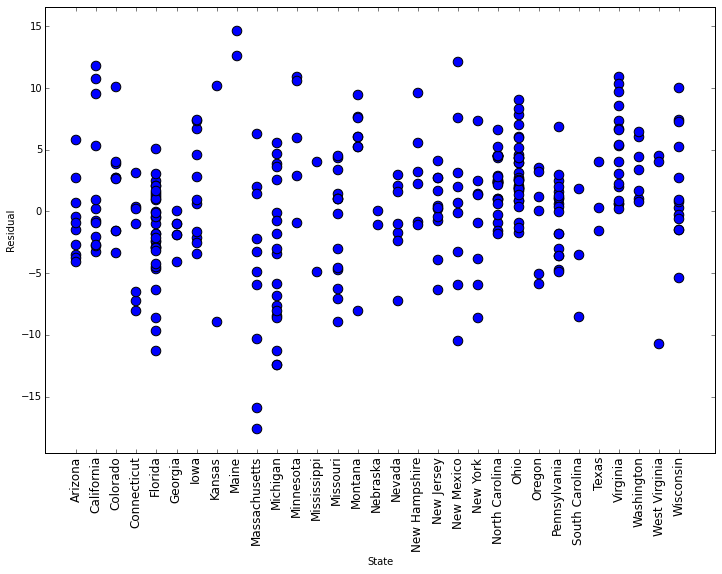

In [142]:
fig, axes = plt.subplots(figsize=(12,8), subplot_kw={"ylabel" : "Residual",
                                                     "xlabel" : "State"})
i = 0
for state, group in state_resid_group:
    x = [i] * len(group)
    axes.scatter(x, group["resid"], s=91)
    i += 1
states = m_regression_data.State.unique()
states.sort()
#axes.xaxis.get_major_locator().set_params(nbins=len(states))
axes.margins(.05, .05)
axes.xaxis.set_ticks(range(31))
axes.xaxis.set_ticklabels(states);
for label in axes.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize('large')

In [143]:
demo_data = demo_data.drop(demo_data.index[demo_data['State'] == 'District of Columbia'])
demo_data.reset_index(drop=True, inplace=True);

In [144]:
exog = demo_data[["PVI", "per_hisp", "per_black", "average_income", "educ_coll"]]
exog["const"] = 1

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [145]:
state_m = m_model.predict(exog)

In [146]:
state_m

array([-15.4217, -21.6313,  -5.0082, -10.561 ,  16.1516,   1.9687,  10.9842,  14.074 ,   2.0836,  -4.6565,  18.1919, -25.1584,  15.7641,  -7.8211,   1.3951,
       -17.1674, -14.4888,  -9.6044,   6.7223,  17.5189,  18.47  ,   8.243 ,   2.4987,  -8.0447,  -3.1677, -11.2639, -19.1112,   5.3443,   0.8928,   8.2712,
        10.5977,  19.1728,  -1.8028, -16.6034,  -0.1732, -24.4563,   6.9845,   4.29  ,  18.3768,  -7.1117, -14.4658, -11.14  ,  -8.1462, -29.3198,  18.9368,
        -0.9413,   7.9092, -12.3842,   3.4667, -31.8014])

In [147]:
unit_m = (state_m - state_m.min())/(state_m.max() - state_m.min())

In [148]:
unit_m *= 2

In [149]:
m_correction = zip(demo_data.State, unit_m)

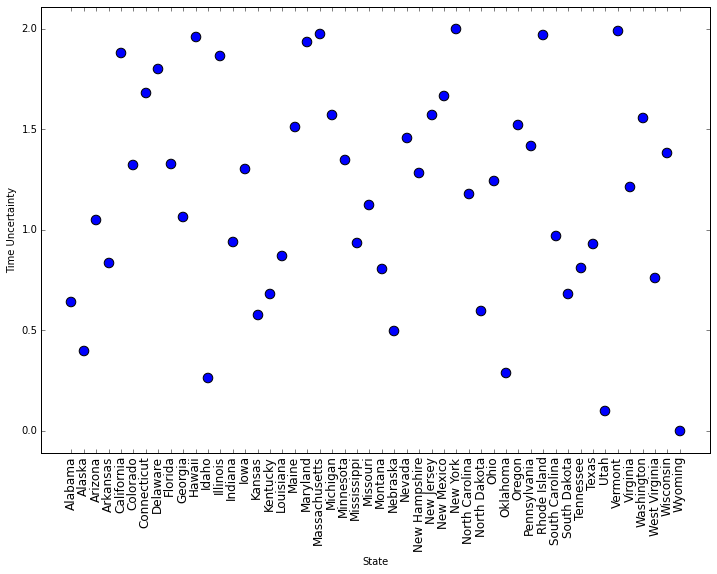

In [150]:
fig, axes = plt.subplots(figsize=(12,8), subplot_kw={"ylabel" : "Time Uncertainty",
                                                     "xlabel" : "State"})

axes.scatter(range(len(unit_m)), unit_m, s=91)

axes.margins(.05, .05)
axes.xaxis.set_ticks(range(len(unit_m)))
axes.xaxis.set_ticklabels(demo_data.State);
for label in axes.xaxis.get_ticklabels():
    label.set_rotation(90)
    label.set_fontsize('large')

In [151]:
m_correction

[('Alabama', 0.64266809431777716),
 ('Alaska', 0.39903009038642717),
 ('Arizona', 1.051246922603376),
 ('Arkansas', 0.83337963581144936),
 ('California', 1.881462353213686),
 ('Colorado', 1.324988270334106),
 ('Connecticut', 1.6787175119991067),
 ('Delaware', 1.799946616374807),
 ('Florida', 1.3294994223427019),
 ('Georgia', 1.0650469049673559),
 ('Hawaii', 1.9615175450935425),
 ('Idaho', 0.26064183981635736),
 ('Illinois', 1.8662598338917602),
 ('Indiana', 0.94088023761213702),
 ('Iowa', 1.3024853082050274),
 ('Kansas', 0.57417594043010256),
 ('Kentucky', 0.67927212280317917),
 ('Louisiana', 0.87091088640015846),
 ('Maine', 1.5115003017124518),
 ('Maryland', 1.9351096983105949),
 ('Massachusetts', 1.972427859773499),
 ('Michigan', 1.5711658872394041),
 ('Minnesota', 1.3457855871862894),
 ('Mississippi', 0.93210857837494054),
 ('Missouri', 1.1234597785092511),
 ('Montana', 0.80580138724827355),
 ('Nebraska', 0.49790708186789584),
 ('Nevada', 1.4574319092076984),
 ('New Hampshire', 1.28

In [152]:
trends = pandas.DataFrame(trends, columns=["State", "trend"])
m_correction = pandas.DataFrame(m_correction, columns=["State", "m_correction"])

In [153]:
trends = trends.merge(m_correction, on="State")

In [154]:
trends.set_index("State", inplace=True)

In [155]:
trends = trends.product(axis=1)

### Snapshot: Combine Trend Estimates and State Polls

In [156]:
state_polls.name = "poll"
state_polls

State  Pollster                   
AZ     Public Policy Polling (PPP)    -9.168494
       Rasmussen                     -10.209446
CA     Field Poll (CA)                23.343924
       Public Policy Polling (PPP)    20.999075
       Rasmussen                      22.000000
       SurveyUSA                      22.123414
CO     American Research Group         2.000000
       Public Policy Polling (PPP)     5.469907
       Rasmussen                      -1.573788
CT     Public Policy Polling (PPP)    12.757757
       Quinnipiac                      7.293983
       Rasmussen                       8.000000
                                        ...    
VA     Mason-Dixon                     1.000000
       Public Policy Polling (PPP)     5.095802
       Quinnipiac                      0.578138
       Rasmussen                       0.891780
VT     Public Policy Polling (PPP)    20.000000
WA     Public Policy Polling (PPP)    13.050886
       Rasmussen                      11.000000
     

In [157]:
state_polls = state_polls.reset_index()
state_polls.State = state_polls.State.replace(states_abbrev_dict)

In [158]:
trends.name = "poll"
trends

State
Wisconsin         7.440163
North Dakota      3.206165
Nebraska          2.677124
Ohio              6.672285
Pennsylvania      7.613838
Indiana           5.058881
Iowa              7.003142
Arizona           5.652295
Maine             8.126964
Missouri          6.040566
Michigan          8.447772
Montana           4.332595
                    ...   
Hawaii            8.851564
Vermont           8.983443
Maryland          8.732396
Minnesota         6.073006
Illinois          8.421703
New Mexico        5.457221
North Carolina    3.861141
Georgia           3.493845
West Virginia     2.499209
South Carolina    3.177833
Tennessee         2.659344
Mississippi       3.057746
Name: poll, dtype: float64

In [159]:
trends = trends.reset_index()
trends["Pollster"] = "National"

In [160]:
trends

,State,poll,Pollster
0,Wisconsin,7.440163,National
1,North Dakota,3.206165,National
2,Nebraska,2.677124,National
3,Ohio,6.672285,National
4,Pennsylvania,7.613838,National
5,Indiana,5.058881,National
6,Iowa,7.003142,National
7,Arizona,5.652295,National
8,Maine,8.126964,National
9,Missouri,6.040566,National


In [161]:
polls = pandas.concat((state_polls, trends))

In [162]:
weights

,Pollster,Weight,PIE
0,ABC / Washington Post,0.95,1.41
1,American Research Group,0.65,1.76
2,CBS / New York Times,0.66,1.84
3,Chicago Trib. / MarketShares,1.16,1.13
4,CNN / Opinion Research,0.77,1.59
5,Columbus Dispatch (OH),0.50,6.76
6,EPIC-MRA,0.75,1.65
7,Fairleigh-Dickinson (NJ),0.71,1.72
8,Field Poll (CA),1.33,0.88
9,Fox / Opinion Dynamics,0.79,1.60


In [163]:
natl_weight = pandas.DataFrame([["National", weights.Weight.mean(), weights.PIE.mean()]],
                                columns=["Pollster", "Weight", "PIE"])
weights = pandas.concat((weights, natl_weight)).reset_index(drop=True)

In [164]:
polls = polls.merge(weights, on="Pollster", how="left")

In [165]:
polls = polls.sort("State")

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [166]:
def weighted_mean(group):
    return (group["poll"] * group["Weight"] / group["Weight"].sum()).sum()

In [167]:
group

,resid,State
304,5.224651,Wisconsin
305,7.432851,Wisconsin
306,0.277203,Wisconsin
307,10.002459,Wisconsin
308,0.728450,Wisconsin
309,2.679444,Wisconsin
310,-0.268988,Wisconsin
311,0.890637,Wisconsin
312,7.240347,Wisconsin
313,-0.644929,Wisconsin


In [168]:
results = polls.groupby("State").aggregate(weighted_mean)["poll"]

In [169]:
results

State
Arizona           -5.453958
California        19.966475
Colorado           2.667843
Connecticut        8.936227
Florida            2.170963
Georgia           -8.811154
Hawaii            18.584803
Illinois          15.477867
Indiana           -7.340970
Iowa               2.038001
Kansas            -9.766281
Maine             12.222222
                    ...    
Pennsylvania       5.436914
Rhode Island      13.236853
South Carolina    -6.334382
South Dakota      -1.522121
Tennessee         -2.521086
Texas             -2.295507
Utah             -29.179269
Vermont           14.891764
Virginia           2.420244
Washington        12.312505
West Virginia     -9.436884
Wisconsin          4.530315
Name: poll, dtype: float64

In [170]:
results = results.reset_index()
results["obama"] = 0
results["romney"] = 0
results.ix[results["poll"] > 0, ["obama"]] = 1
results.ix[results["poll"] < 0, ["romney"]] = 1

In [171]:
results[["State", "poll"]].to_csv("./data/2012-predicted.csv", index=False)

In [172]:
electoral_votes = pandas.read_csv("./data/electoral_votes.csv")

In [173]:
electoral_votes.sort("State", inplace=True)
electoral_votes.reset_index(drop=True, inplace=True)

/home/jim/INSTALL/anaconda3/envs/pydata538/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [174]:
results = electoral_votes.merge(results, on="State", how="left")

In [175]:
results = results.set_index("State")
red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Kentucky", "Louisiana",
              "Oklahoma", "Wyoming"]
blue_states = ["Delaware", "District of Columbia"]
results.ix[red_states, ["romney"]] = 1
results.ix[red_states, ["obama"]] = 0
results.ix[blue_states, ["obama"]] = 1
results.ix[blue_states, ["romney"]] = 0

In [307]:
results

,Votes,poll,obama,romney
State,,,,
Alabama,9,NaN,0,1
Alaska,3,NaN,0,1
Arizona,11,-5.453958,0,1
Arkansas,6,NaN,0,1
California,55,19.966475,1,0
Colorado,9,2.667843,1,0
Connecticut,7,8.936227,1,0
Delaware,3,NaN,1,0
District of Columbia,3,NaN,1,0


In [177]:
results["Votes"].mul(results["obama"]).sum()

328.0

In [178]:
results["Votes"].mul(results["romney"]).sum()

210.0

In [179]:
results

,Votes,poll,obama,romney
State,,,,
Alabama,9,NaN,0,1
Alaska,3,NaN,0,1
Arizona,11,-5.453958,0,1
Arkansas,6,NaN,0,1
California,55,19.966475,1,0
Colorado,9,2.667843,1,0
Connecticut,7,8.936227,1,0
Delaware,3,NaN,1,0
District of Columbia,3,NaN,1,0


TODO:

Divide undecided voters probabilistically.

Do historical adjustments based on how polls changed in the past conditional on "election environment"

"Error analysis"

# Error Analysis

Polling errors are from sample variance and other ambiguities inherent to polling

Model the Polling error, based on these factors:

* The error is higher in races with fewer polls
* The error is higher in races where the polls disagree with one another.
* The error is higher when there are a larger number of undecided voters.
* The error is higher when the margin between the two candidates is lopsided.
* The error is higher the further one is from Election Day.

We don't have the data to model this but we will guestimate so we can show you the full process.

We need error estimates for each state (local error) and for the generic ballot (national error). These are combined to get the total error for each state.

The national error creates correlation between the state results.

$$
LocalError = \sqrt{TotalError^{2} + NationalError^{2}}
$$



Source: http://fivethirtyeight.blogs.nytimes.com/methodology/?_r=0

In [282]:
national_margin_of_error = 2.5
local_margin_of_error = Series(np.array([1.3, 2.2, 1.3, 2.5, 2.2, 1.2, 2.2, 1.5]), index=tossup)
local_margin_of_error

Colorado         1.3
Florida          2.2
Iowa             1.3
New Hampshire    2.5
Nevada           2.2
Ohio             1.2
Virginia         2.2
Wisconsin        1.5
dtype: float64

In [283]:
np.random.seed(1)
N = 10000
local_error_sim = DataFrame(np.random.randn(N, len(tossup)), columns=tossup).multiply(local_margin_of_error)
national_error_sim = Series(np.random.randn(N) * national_margin_of_error)

In [284]:
# local error deviations
local_error_sim.iloc[:10,]

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin
0,2.111649,-1.345864,-0.686623,-2.682422,1.903897,-2.761846,3.838586,-1.141810
1,0.414751,-0.548615,1.900740,-5.150352,-0.709318,-0.460865,2.494293,-1.649837
2,-0.224157,-1.931289,0.054878,1.457038,-2.421362,1.373668,1.983500,0.753742
3,1.171113,-1.504201,-0.159757,-2.339424,-0.589354,0.636427,-1.521654,-0.595130
4,-0.893325,-1.859452,-0.872620,-0.031661,-2.458083,0.281299,3.651565,1.113066
5,-0.249386,-1.952784,-0.971306,4.231137,0.111777,-0.764395,0.420014,3.150383
6,0.156207,1.357847,0.390221,-0.880625,-2.513540,-0.419211,-0.459567,0.879935
7,1.090678,2.048425,0.371264,2.212853,-1.659675,1.503442,1.128446,-0.447139
8,0.635074,-0.166258,1.471118,3.799542,4.808266,-1.675796,-3.177050,-0.756699
9,0.208048,1.927572,0.410325,-5.055503,-0.673649,0.993570,0.506208,1.143017


In [285]:
# total error deviations
total_error_sim = local_error_sim.add(national_error_sim, axis='rows')
total_error_sim.iloc[:10,]

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin
0,5.309166,1.851653,2.510894,0.515095,5.101414,0.435670,7.036103,2.055707
1,0.010694,-0.952671,1.496684,-5.554408,-1.113375,-0.864922,2.090236,-2.053894
2,-1.796023,-3.503155,-1.516988,-0.114828,-3.993228,-0.198198,0.411633,-0.818125
3,-2.074291,-4.749605,-3.405161,-5.584828,-3.834758,-2.608977,-4.767058,-3.840534
4,2.319566,1.353438,2.340271,3.181229,0.754808,3.494189,6.864455,4.325957
5,-1.913171,-3.616568,-2.635090,2.567352,-1.552008,-2.428179,-1.243771,1.486598
6,-0.276474,0.925166,-0.042459,-1.313305,-2.946220,-0.851892,-0.892248,0.447254
7,1.280872,2.238618,0.561457,2.403047,-1.469482,1.693635,1.318639,-0.256946
8,1.049680,0.248349,1.885724,4.214148,5.222872,-1.261189,-2.762444,-0.342093
9,-3.075249,-1.355726,-2.872972,-8.338800,-3.956946,-2.289728,-2.777089,-2.140280


In [286]:
# to that we add the model predictions for each state
simulated_poll_predictions = total_error_sim.add(results.ix[tossup, 'poll'])
simulated_poll_predictions.iloc[:10,]

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin
0,7.977009,4.022616,4.548895,-1.031961,10.194544,4.611726,9.456347,6.586022
1,2.678537,1.218292,3.534685,-7.101465,3.979756,3.311133,4.510480,2.476422
2,0.871820,-1.332192,0.521013,-1.661884,1.099902,3.977857,2.831878,3.712191
3,0.593552,-2.578642,-1.367160,-7.131884,1.258372,1.567078,-2.346813,0.689781
4,4.987409,3.524401,4.378272,1.634173,5.847938,7.670245,9.284700,8.856272
5,0.754672,-1.445605,-0.597089,1.020296,3.541123,1.747876,1.176474,6.016913
6,2.391369,3.096129,1.995542,-2.860361,2.146910,3.324164,1.527997,4.977570
7,3.948715,4.409581,2.599458,0.855990,3.623648,5.869691,3.738883,4.273370
8,3.717523,2.419312,3.923725,2.667092,10.316002,2.914866,-0.342200,4.188223
9,-0.407406,0.815238,-0.834971,-9.885856,1.136184,1.886328,-0.356844,2.390035


In [287]:
simulated_poll_predictions.corr()

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin
Colorado,1.000000,0.661364,0.782967,0.632265,0.666076,0.801657,0.663607,0.762725
Florida,0.661364,1.000000,0.666801,0.517375,0.559425,0.671366,0.558036,0.643287
Iowa,0.782967,0.666801,1.000000,0.625854,0.659162,0.799275,0.661989,0.763126
New Hampshire,0.632265,0.517375,0.625854,1.000000,0.536203,0.640725,0.537008,0.612874
Nevada,0.666076,0.559425,0.659162,0.536203,1.000000,0.674964,0.555986,0.646501
Ohio,0.801657,0.671366,0.799275,0.640725,0.674964,1.000000,0.669790,0.770683
Virginia,0.663607,0.558036,0.661989,0.537008,0.555986,0.669790,1.000000,0.641731
Wisconsin,0.762725,0.643287,0.763126,0.612874,0.646501,0.770683,0.641731,1.000000


In [288]:
bins = np.arange(-10, 10, 0.2)
histograms = {s: np.histogram(simulated_poll_predictions[s], bins=bins, density=True)[0] for s in tossup}

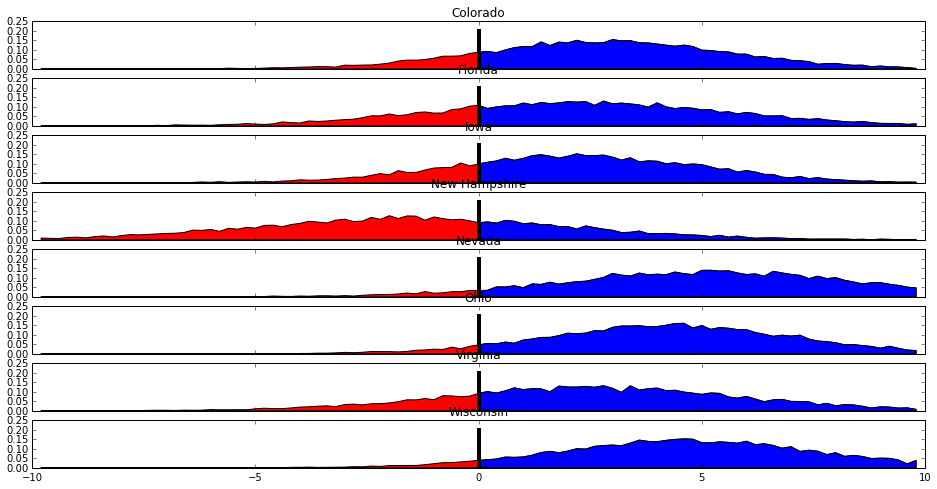

In [289]:
fig, axes = plt.subplots(len(tossup), 1, sharex=True, figsize=(16,  8))

for state, ax in zip(tossup, axes):
    ax.fill_between(bins[1:], 0, histograms[state], facecolor='red')
    ax.fill_between(bins[50:], 0, histograms[state][49:], facecolor='blue')
    ax.set_title(state)
    ax.plot([0.0, 0.0], [0, 0.2], color='k', linewidth=4)  

In [308]:
# electorial votes for the non-tossup states
solid = set(results.index).difference(tossup)
solid_obama = results["Votes"].mul(results["obama"])[solid].sum()
solid_romney = results["Votes"].mul(results["romney"])[solid].sum()

print "Solid Obama Electorial College Votes", solid_obama
print "Solid Romney Electorial College Votes", solid_romney

Solid Obama Electorial College Votes 237.0
Solid Romney Electorial College Votes 206.0


In [312]:
# electorial college votes for the tossup states, from the simulation
tossup_electoral_votes = electoral_votes.set_index('State').ix[tossup, 'Votes']

obama_simulated_electorial_college = (simulated_poll_predictions > 0).multiply(tossup_electoral_votes)
obama_simulated_electorial_college['Solid States'] = solid_obama
obama_simulated_electorial_college['Total'] = obama_simulated_electorial_college.sum(axis=1)

romney_simulated_electorial_college = (simulated_poll_predictions < 0).multiply(tossup_electoral_votes)
romney_simulated_electorial_college['Solid States'] = solid_romney
romney_simulated_electorial_college['Total'] = romney_simulated_electorial_college.sum(axis=1)

In [313]:
obama_simulated_electorial_college.iloc[:10,]

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin,Solid States,Total
0,9,29,6,0,6,18,13,10,237,328
1,9,29,6,0,6,18,13,10,237,328
2,9,0,6,0,6,18,13,10,237,299
3,9,0,0,0,6,18,0,10,237,280
4,9,29,6,4,6,18,13,10,237,332
5,9,0,0,4,6,18,13,10,237,297
6,9,29,6,0,6,18,13,10,237,328
7,9,29,6,4,6,18,13,10,237,332
8,9,29,6,4,6,18,0,10,237,319
9,0,29,0,0,6,18,0,10,237,300


In [314]:
romney_simulated_electorial_college.iloc[:10,]

,Colorado,Florida,Iowa,New Hampshire,Nevada,Ohio,Virginia,Wisconsin,Solid States,Total
0,0,0,0,4,0,0,0,0,206,210
1,0,0,0,4,0,0,0,0,206,210
2,0,29,0,4,0,0,0,0,206,239
3,0,29,6,4,0,0,13,0,206,258
4,0,0,0,0,0,0,0,0,206,206
5,0,29,6,0,0,0,0,0,206,241
6,0,0,0,4,0,0,0,0,206,210
7,0,0,0,0,0,0,0,0,206,206
8,0,0,0,0,0,0,13,0,206,219
9,9,0,6,4,0,0,13,0,206,238


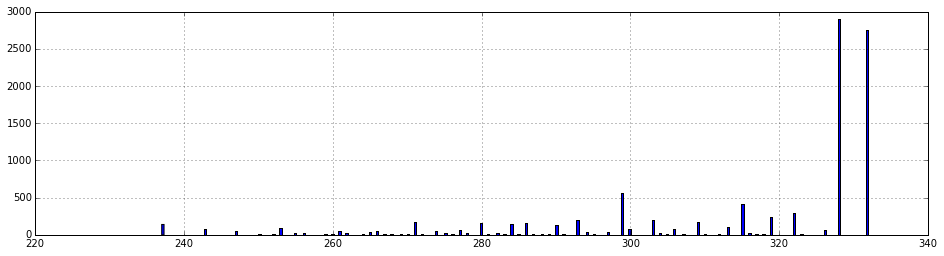

In [319]:
obama_simulated_electorial_college['Total'].hist(bins=300, figsize=(16, 4))

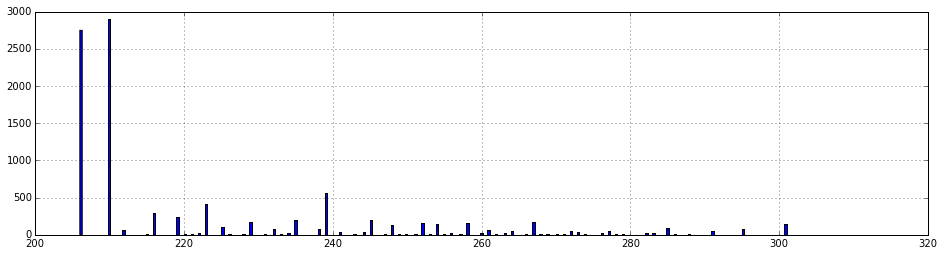

In [320]:
romney_simulated_electorial_college['Total'].hist(bins=300, figsize=(16, 4))

In [321]:
sum(obama_simulated_electorial_college['Total'] > romney_simulated_electorial_college['Total']) / float(N)

0.93440000000000001